In [12]:
from timesteppers import IMEXEuler, IMEXSP, IMEXTrap
from RDModels import GrayScott, HeatEquation
import numpy as np
import numpy.typing as npt
from scipy.sparse.linalg import spsolve
from typing import Optional


Below the heat equation is solved using IMEX Euler

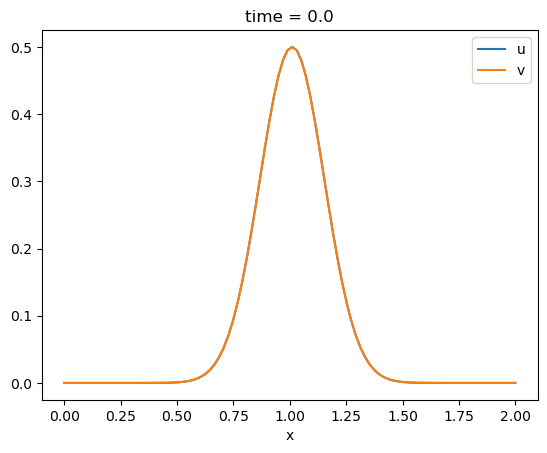

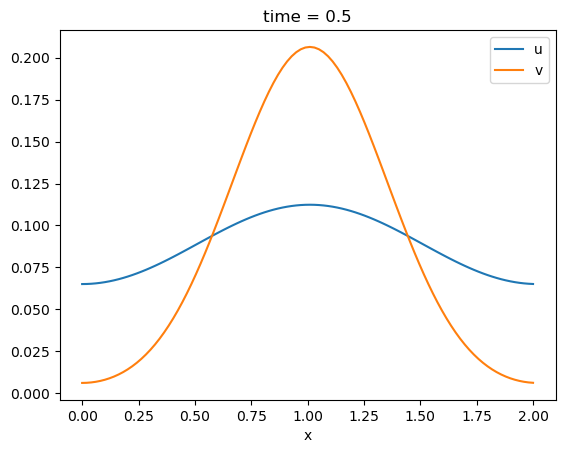

In [13]:
# discretization parameters
L: int = 2
Nx: int = 100
Nt: int = 100
discretization: npt.NDArray = np.array([Nx], dtype=int)
tmin: float = 0.0 
tmax: float = 0.5

# Model parameters
Du: float = 4e-1
Dv: float = 1e-1

# Initial condition
x: npt.NDArray = np.linspace(0, L, Nx, endpoint=False)
perturb: npt.NDArray = np.exp(-25*np.power(x-1, 2))*0.5
upart: npt.NDArray = np.copy(perturb)
vpart: npt.NDArray = np.copy(perturb)
u0: npt.NDArray = np.hstack((upart, vpart))

# Make PDE object
h1: HeatEquation = HeatEquation(discretization, L, Du, Dv)

# Make time stepper
imex1: IMEXEuler = IMEXEuler(h1)

# Integrate
imex1.integrate(tmin, tmax, Nt, u0)
res: Optional[npt.NDArray] = imex1.res

# Plot
h1.plot(imex1.time, 0, imex1.res)
h1.plot(imex1.time, imex1.time.size-1, imex1.res)



Code equation solution to heat equation on periodic domain.

Compute exact solution at t = 0.5. Compute error of IMEX Euler

In [16]:
import matplotlib.pyplot as plt

mu = 2
Nxs: npt.NDArray = np.logspace(1.5, 3, 20, dtype=int)
dxs: npt.NDArray = (2*L)/(Nxs-1)
dts: npt.NDArray = mu*np.power(dxs, 2)/(2*Dv)
Nts: npt.NDArray = (((tmax - tmin)/dts) + 1).astype(int)
Nx: int = Nxs[10] 

# Initial condition
xs = np.linspace(0, 2*L, Nx, endpoint=False)
x0part: npt.NDArray = np.cos(2*np.pi*xs/(2*L))
x0 = np.hstack((x0part, x0part))

# Make PDE object & compute exact solution
discretization: npt.NDArray = np.array([Nx])
h1: HeatEquation = HeatEquation(discretization, 2*L, Du, Dv)
imex3: IMEXTrap = IMEXTrap(h1)
res = imex3.integrate(tmin, tmax, Nts[-1]*10, x0)
exactSol: npt.NDArray = res[-1, Nx:]

# Compute errors
err: npt.NDArray = np.zeros((Nts.size, 3), dtype=np.float64)
normType: None | str | float = np.inf
for index, Nt in enumerate(Nts):    
    # Make time steppers
    imex1: IMEXEuler = IMEXEuler(h1)
    imex2: IMEXSP = IMEXSP(h1)
    imex3: IMEXTrap = IMEXTrap(h1)
    
    # Integrate imex1
    res = imex1.integrate(tmin, tmax, Nt, x0)
    vmax: npt.NDArray = res[-1, Nx:]
    err[index, 0] = np.linalg.norm(vmax - exactSol, normType) # type: ignore

    # Integrate imex2
    res = imex2.integrate(tmin, tmax, Nt, x0)
    vmax: npt.NDArray = res[-1, Nx:]
    err[index, 1] = np.linalg.norm(vmax - exactSol, normType) # type: ignore

    # Integrate imex3
    res = imex3.integrate(tmin, tmax, Nt, x0)
    vmax: npt.NDArray = res[-1, Nx:]
    err[index, 2] = np.linalg.norm(vmax - exactSol, normType)  # type: ignore


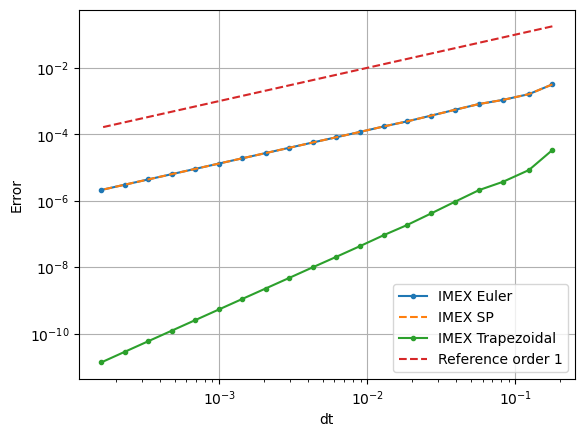

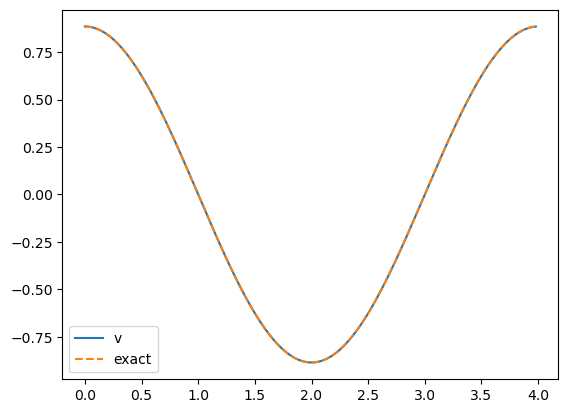

In [17]:
plt.figure(1)
plt.loglog(dts, err[:, 0], '.-', label='IMEX Euler')
plt.loglog(dts, err[:, 1], '--', label='IMEX SP')
plt.loglog(dts, err[:, 2], '.-', label='IMEX Trapezoidal')
plt.loglog(dts, dts, '--', label='Reference order 1')
plt.xlabel('dt')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()


plt.figure(2)
plt.plot(xs, vmax, label='v')
plt.plot(xs, exactSol, '--', label='exact')
plt.legend()
plt.show()

In [18]:
np.argmax(vmax - exactSol)
np.max(vmax - exactSol)

1.3672174503653878e-11

In [14]:

# def exactHeatSol(x: npt.NDArray, t: float, Acoeff, Bcoeff, D) -> npt.NDArray:
#     s = len(Acoeff)
#     res: npt.NDArray = np.zeros_like(x)
#     for i in range(s):
#         texp = np.exp(-D*t*np.power(i*np.pi/L, 2))
#         res += Acoeff[i]*np.cos(i*np.pi*x/L)*texp + Bcoeff[i]*np.sin(i*np.pi*x/L)*texp
#     return res

In [15]:
# from scipy.integrate import quad

# Nterms: int = 70
# initf = lambda x: -np.cos(2*np.pi*x/(2*L))  # cosine with periode L
# Afunc = lambda x, n : initf(x)*np.cos(n*np.pi*x/L)
# Bfunc = lambda x, n : initf(x)*np.sin(n*np.pi*x/L)

# Acoeff: npt.NDArray = np.zeros((Nterms, ))
# Bcoeff: npt.NDArray = np.zeros_like(Acoeff)

# i1, _ = quad(initf, -L, L)
# Acoeff[0] = i1/(2*L)
# for i in range(1, Nterms):
#     i1, _ = quad(Afunc, -L, L, args=(i, ))
#     i2, _ = quad(Bfunc, -L, L, args=(i, ))
#     Acoeff[i] = i1/L
#     Bcoeff[i] = i2/L
# exactSol: npt.NDArray = exactHeatSol(np.linspace(-L, L, Nx, endpoint=False), tmax, Acoeff, Bcoeff, Dv)
